In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('hw2_data/snli_train.tsv',delimiter='\t')
val = pd.read_csv("hw2_data/snli_val.tsv",delimiter='\t')

In [3]:
train_data = train[['sentence1','sentence2']]
train_targets = np.array(train['label'])


val_data = val[['sentence1','sentence2']]
val_targets = np.array(val['label'])


In [4]:
train_targets = np.where(train_targets=='entailment',1,train_targets)
train_targets = np.where(train_targets=='neutral',0,train_targets)
train_targets = np.where(train_targets=='contradiction',2,train_targets)


val_targets = np.where(val_targets=='entailment',1,val_targets)
val_targets = np.where(val_targets=='neutral',0,val_targets)
val_targets = np.where(val_targets=='contradiction',2,val_targets)




In [5]:
ft_home = './'
words_to_load = 50000

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1


with open(ft_home + 'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+2, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = ['<pad>','<unk>']
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+2
        idx2words_ft[i+2] = s[0]
        ordered_words_ft.append(s[0])
    words_ft['<pad>'] = PAD_IDX 
    words_ft['<unk>'] = UNK_IDX   
    

In [6]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [words_ft[token] if token in words_ft else UNK_IDX for token in tokens.split(' ')]
        indices_data.append(index_list)
    return indices_data

train_data_sentence1_indices = token2index_dataset(train_data['sentence1'])
train_data_sentence2_indices = token2index_dataset(train_data['sentence2'])

val_data_sentence1_indices = token2index_dataset(val_data['sentence1'])
val_data_sentence2_indices = token2index_dataset(val_data['sentence2'])


# double checking
print ("Train dataset of sentence1 size is {}".format(len(train_data_sentence1_indices)))
print ("Train dataset of sentence2 size is {}".format(len(train_data_sentence2_indices)))


Train dataset of sentence1 size is 100000
Train dataset of sentence2 size is 100000


In [7]:
#MAX_SENTENCE_LENGTH = 80
    
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list_1,data_list_2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """

        token_idx_1 = self.data_list_1[key]
        token_idx_2 = self.data_list_2[key]
        label = self.target_list[key]
        return [token_idx_1,token_idx_2, len(token_idx_1),len(token_idx_2), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[2])
        #print(datum[2])
        length_list_2.append(datum[3])
        #print(datum[3])

    # padding
    for datum in batch:
        
        max_s1 = max (length_list_1) 
        max_s2 = max (length_list_2) 


        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_s1-datum[2])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        
        #print(data_list_1[0])
        
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_s2-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_2.append(padded_vec_2)
        #print(data_list_2[0])
        
    return [torch.from_numpy(np.array(data_list_1)),torch.from_numpy(np.array(data_list_2)),torch.from_numpy(np.array(length_list_1)), torch.LongTensor(length_list_2),torch.LongTensor(label_list)]

BATCH_SIZE = 100
train_dataset = NewsGroupDataset(train_data_sentence1_indices,train_data_sentence2_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_sentence1_indices,val_data_sentence2_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


---
## Search for the hidden layer sizes

In [8]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class SNLI_RNN(nn.Module):
    """
    SNLI classification model
    """
    def __init__(self, embeddings,vocab_size,emb_dim,hidden_size,num_layers,num_classes,FC_hiden):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(SNLI_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = emb_dim
        
        # pay attention to padding_idx 
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)

                

        
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=hidden_size,num_layers=num_layers,batch_first=True,
                        bidirectional=True)

        self.linear = nn.Sequential(
            #nn.Linear(hidden_size,FC_hiden),
            nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).cuda()

        return hidden
    
    
    def forward(self, data_1,data_2, length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        hidden1 = self.init_hidden(batch_size_1)
        hidden2 = self.init_hidden(batch_size_2)
   
        #S1 = self.embed(data_1)
        #print(data_1.size())
        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_dim).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_dim).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        # sort the seqs in des order
        _, idx_sort_1 = torch.sort(length_1, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        S1 = S1.index_select(0, idx_sort_1)
        length_1 = list(length_1[idx_sort_1])

        _, idx_sort_2 = torch.sort(length_2, dim=0, descending=True)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)
        S2 = S2.index_select(0, idx_sort_2)
        length_2 = list(length_2[idx_sort_2])
        
        #print("batch size",S1.size())

        # transform pytorch tensor to padded sequence, pack padded sequence
        S1 = torch.nn.utils.rnn.pack_padded_sequence(S1, np.array(length_1), batch_first=True)
        S2 = torch.nn.utils.rnn.pack_padded_sequence(S2, np.array(length_2), batch_first=True)
       
        _,S1 = self.rnn(S1,hidden1)
        _,S2 = self.rnn(S2,hidden2)
        
        #print("batch size",S1.size())
        
        
        S1 = torch.sum(S1,0)
        S2 = torch.sum(S2,0)
        
        #print("batch size",S2.size())

        # Unsort
        S1 = S1.index_select(0,idx_unsort_1)
        S2 = S2.index_select(0,idx_unsort_2)

        
        #out = torch.mul(S1, S2)
        out = torch.cat([S1, S2], 1)
        #print(out.size())

             
        # return logits
        out = self.linear(out)
        #print(out.size())

        return out


In [9]:

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_1,data_2, lengths_1,lengths_2, labels in loader:
        data_batch1,data_batch2, length_batch1,length_batch2, label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
        outputs = F.softmax(model(data_batch1,data_batch2, length_batch1,length_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
       
        #print(outputs)
        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [ ]:

hidden_sizes = [50,100,140,160,200,250]

learning_rate = 0.001
num_epochs = 10 # number epoch to train


train_losses=np.zeros((num_epochs,len(hidden_sizes)))
val_accs=np.zeros((num_epochs,len(hidden_sizes)))
train_accs=np.zeros((num_epochs,len(hidden_sizes)))

for count, em in enumerate(hidden_sizes):
    model = SNLI_RNN(loaded_embeddings_ft,50000,300,em,num_layers=1,num_classes=3,FC_hiden=50).cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    

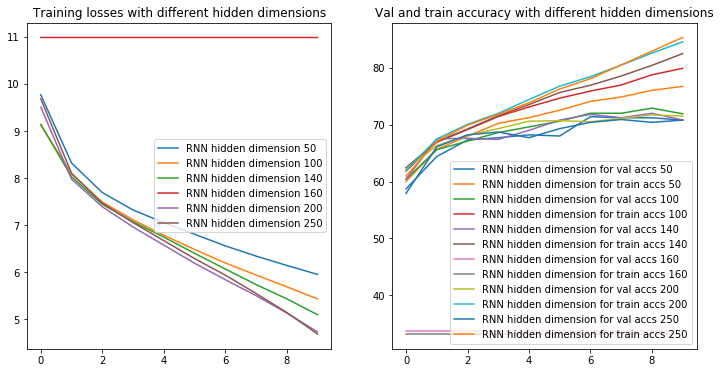

In [11]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "RNN hidden dimension " +str(hidden_sizes[i])) 

axs[0].set_title("Training losses with different hidden dimensions")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "RNN hidden dimension for val accs " +str(hidden_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "RNN hidden dimension for train accs " +str(hidden_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()



In [38]:
y()

/home/tl1698/nlp/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  """Entry point for launching an IPython kernel.


---
## Investigate whether element-wise multiplication helps

In [12]:
class SNLI_RNN(nn.Module):
    """
    SNLI classification model
    """
    def __init__(self, embeddings,vocab_size,emb_dim,hidden_size,num_layers,num_classes,FC_hiden):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(SNLI_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = emb_dim
        
        # pay attention to padding_idx 
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)

                

        
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=hidden_size,num_layers=num_layers,batch_first=True,
                        bidirectional=True)

        self.linear = nn.Sequential(
            nn.Linear(hidden_size,FC_hiden),
            #nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).cuda()

        return hidden
    
    
    def forward(self, data_1,data_2, length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        hidden1 = self.init_hidden(batch_size_1)
        hidden2 = self.init_hidden(batch_size_2)
   
        #S1 = self.embed(data_1)
        #print(data_1.size())
        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_dim).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_dim).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        # sort the seqs in des order
        _, idx_sort_1 = torch.sort(length_1, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        S1 = S1.index_select(0, idx_sort_1)
        length_1 = list(length_1[idx_sort_1])

        _, idx_sort_2 = torch.sort(length_2, dim=0, descending=True)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)
        S2 = S2.index_select(0, idx_sort_2)
        length_2 = list(length_2[idx_sort_2])
        
        #print("batch size",S1.size())

        # transform pytorch tensor to padded sequence, pack padded sequence
        S1 = torch.nn.utils.rnn.pack_padded_sequence(S1, np.array(length_1), batch_first=True)
        S2 = torch.nn.utils.rnn.pack_padded_sequence(S2, np.array(length_2), batch_first=True)
       
        _,S1 = self.rnn(S1,hidden1)
        _,S2 = self.rnn(S2,hidden2)
        
        #print("batch size",S1.size())
        
        
        S1 = torch.sum(S1,0)
        S2 = torch.sum(S2,0)
        
        #print("batch size",S2.size())

        # Unsort
        S1 = S1.index_select(0,idx_unsort_1)
        S2 = S2.index_select(0,idx_unsort_2)

        
        out = torch.mul(S1, S2)
        #out = torch.cat([S1, S2], 1)
        #print(out.size())

             
        # return logits
        out = self.linear(out)
        #print(out.size())

        return out


In [14]:
hidden_sizes = [100,160,200,250]

learning_rate = 0.0005
num_epochs = 20 # number epoch to train


train_losses=np.zeros((num_epochs,len(hidden_sizes)))
val_accs=np.zeros((num_epochs,len(hidden_sizes)))
train_accs=np.zeros((num_epochs,len(hidden_sizes)))

for count, em in enumerate(hidden_sizes):
    model = SNLI_RNN(loaded_embeddings_ft,50000,300,em,num_layers=1,num_classes=3,FC_hiden=50).cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    

Epoch: [1/20], Step: [100/1000], Validation Acc: 38.6
Epoch: [1/20], Step: [199/1000], Validation Acc: 41.2
Epoch: [1/20], Step: [298/1000], Validation Acc: 42.0
Epoch: [1/20], Step: [397/1000], Validation Acc: 41.1
Epoch: [1/20], Step: [496/1000], Validation Acc: 44.0
Epoch: [1/20], Step: [595/1000], Validation Acc: 43.8
Epoch: [1/20], Step: [694/1000], Validation Acc: 44.0
Epoch: [1/20], Step: [793/1000], Validation Acc: 44.2
Epoch: [1/20], Step: [892/1000], Validation Acc: 43.7
Epoch: [1/20], Step: [991/1000], Validation Acc: 42.8
Epoch: [2/20], Step: [100/1000], Validation Acc: 45.4
Epoch: [2/20], Step: [199/1000], Validation Acc: 44.4
Epoch: [2/20], Step: [298/1000], Validation Acc: 43.1
Epoch: [2/20], Step: [397/1000], Validation Acc: 46.4
Epoch: [2/20], Step: [496/1000], Validation Acc: 46.4
Epoch: [2/20], Step: [595/1000], Validation Acc: 46.4
Epoch: [2/20], Step: [694/1000], Validation Acc: 47.3
Epoch: [2/20], Step: [793/1000], Validation Acc: 45.0
Epoch: [2/20], Step: [892/10

Epoch: [16/20], Step: [199/1000], Validation Acc: 50.8
Epoch: [16/20], Step: [298/1000], Validation Acc: 50.1
Epoch: [16/20], Step: [397/1000], Validation Acc: 50.9
Epoch: [16/20], Step: [496/1000], Validation Acc: 51.2
Epoch: [16/20], Step: [595/1000], Validation Acc: 51.4
Epoch: [16/20], Step: [694/1000], Validation Acc: 51.2
Epoch: [16/20], Step: [793/1000], Validation Acc: 52.0
Epoch: [16/20], Step: [892/1000], Validation Acc: 51.6
Epoch: [16/20], Step: [991/1000], Validation Acc: 51.7
Epoch: [17/20], Step: [100/1000], Validation Acc: 52.0
Epoch: [17/20], Step: [199/1000], Validation Acc: 51.6
Epoch: [17/20], Step: [298/1000], Validation Acc: 51.7
Epoch: [17/20], Step: [397/1000], Validation Acc: 50.3
Epoch: [17/20], Step: [496/1000], Validation Acc: 51.5
Epoch: [17/20], Step: [595/1000], Validation Acc: 52.6
Epoch: [17/20], Step: [694/1000], Validation Acc: 51.9
Epoch: [17/20], Step: [793/1000], Validation Acc: 49.1
Epoch: [17/20], Step: [892/1000], Validation Acc: 52.7
Epoch: [17

Epoch: [11/20], Step: [298/1000], Validation Acc: 68.9
Epoch: [11/20], Step: [397/1000], Validation Acc: 71.2
Epoch: [11/20], Step: [496/1000], Validation Acc: 70.5
Epoch: [11/20], Step: [595/1000], Validation Acc: 69.6
Epoch: [11/20], Step: [694/1000], Validation Acc: 70.5
Epoch: [11/20], Step: [793/1000], Validation Acc: 70.5
Epoch: [11/20], Step: [892/1000], Validation Acc: 70.4
Epoch: [11/20], Step: [991/1000], Validation Acc: 68.9
Epoch: [12/20], Step: [100/1000], Validation Acc: 70.4
Epoch: [12/20], Step: [199/1000], Validation Acc: 69.7
Epoch: [12/20], Step: [298/1000], Validation Acc: 68.8
Epoch: [12/20], Step: [397/1000], Validation Acc: 69.1
Epoch: [12/20], Step: [496/1000], Validation Acc: 69.3
Epoch: [12/20], Step: [595/1000], Validation Acc: 70.5
Epoch: [12/20], Step: [694/1000], Validation Acc: 69.9
Epoch: [12/20], Step: [793/1000], Validation Acc: 70.8
Epoch: [12/20], Step: [892/1000], Validation Acc: 71.7
Epoch: [12/20], Step: [991/1000], Validation Acc: 70.7
Epoch: [13

Epoch: [6/20], Step: [298/1000], Validation Acc: 69.2
Epoch: [6/20], Step: [397/1000], Validation Acc: 68.0
Epoch: [6/20], Step: [496/1000], Validation Acc: 68.7
Epoch: [6/20], Step: [595/1000], Validation Acc: 67.8
Epoch: [6/20], Step: [694/1000], Validation Acc: 68.7
Epoch: [6/20], Step: [793/1000], Validation Acc: 69.0
Epoch: [6/20], Step: [892/1000], Validation Acc: 69.2
Epoch: [6/20], Step: [991/1000], Validation Acc: 67.5
Epoch: [7/20], Step: [100/1000], Validation Acc: 69.3
Epoch: [7/20], Step: [199/1000], Validation Acc: 67.7
Epoch: [7/20], Step: [298/1000], Validation Acc: 69.6
Epoch: [7/20], Step: [397/1000], Validation Acc: 68.0
Epoch: [7/20], Step: [496/1000], Validation Acc: 68.2
Epoch: [7/20], Step: [595/1000], Validation Acc: 69.1
Epoch: [7/20], Step: [694/1000], Validation Acc: 67.9
Epoch: [7/20], Step: [793/1000], Validation Acc: 69.4
Epoch: [7/20], Step: [892/1000], Validation Acc: 66.9
Epoch: [7/20], Step: [991/1000], Validation Acc: 69.1
Epoch: [8/20], Step: [100/10

Epoch: [1/20], Step: [298/1000], Validation Acc: 46.8
Epoch: [1/20], Step: [397/1000], Validation Acc: 48.6
Epoch: [1/20], Step: [496/1000], Validation Acc: 49.9
Epoch: [1/20], Step: [595/1000], Validation Acc: 56.0
Epoch: [1/20], Step: [694/1000], Validation Acc: 55.2
Epoch: [1/20], Step: [793/1000], Validation Acc: 58.3
Epoch: [1/20], Step: [892/1000], Validation Acc: 55.9
Epoch: [1/20], Step: [991/1000], Validation Acc: 58.1
Epoch: [2/20], Step: [100/1000], Validation Acc: 59.2
Epoch: [2/20], Step: [199/1000], Validation Acc: 60.6
Epoch: [2/20], Step: [298/1000], Validation Acc: 60.5
Epoch: [2/20], Step: [397/1000], Validation Acc: 61.5
Epoch: [2/20], Step: [496/1000], Validation Acc: 60.9
Epoch: [2/20], Step: [595/1000], Validation Acc: 59.6
Epoch: [2/20], Step: [694/1000], Validation Acc: 59.0
Epoch: [2/20], Step: [793/1000], Validation Acc: 60.5
Epoch: [2/20], Step: [892/1000], Validation Acc: 59.0
Epoch: [2/20], Step: [991/1000], Validation Acc: 61.4
Epoch: [3/20], Step: [100/10

Epoch: [16/20], Step: [397/1000], Validation Acc: 69.8
Epoch: [16/20], Step: [496/1000], Validation Acc: 69.3
Epoch: [16/20], Step: [595/1000], Validation Acc: 69.4
Epoch: [16/20], Step: [694/1000], Validation Acc: 69.5
Epoch: [16/20], Step: [793/1000], Validation Acc: 68.8
Epoch: [16/20], Step: [892/1000], Validation Acc: 70.0
Epoch: [16/20], Step: [991/1000], Validation Acc: 69.4
Epoch: [17/20], Step: [100/1000], Validation Acc: 69.9
Epoch: [17/20], Step: [199/1000], Validation Acc: 71.1
Epoch: [17/20], Step: [298/1000], Validation Acc: 67.9
Epoch: [17/20], Step: [397/1000], Validation Acc: 68.2
Epoch: [17/20], Step: [496/1000], Validation Acc: 69.7
Epoch: [17/20], Step: [595/1000], Validation Acc: 68.3
Epoch: [17/20], Step: [694/1000], Validation Acc: 68.5
Epoch: [17/20], Step: [793/1000], Validation Acc: 68.0
Epoch: [17/20], Step: [892/1000], Validation Acc: 68.6
Epoch: [17/20], Step: [991/1000], Validation Acc: 68.7
Epoch: [18/20], Step: [100/1000], Validation Acc: 70.0
Epoch: [18

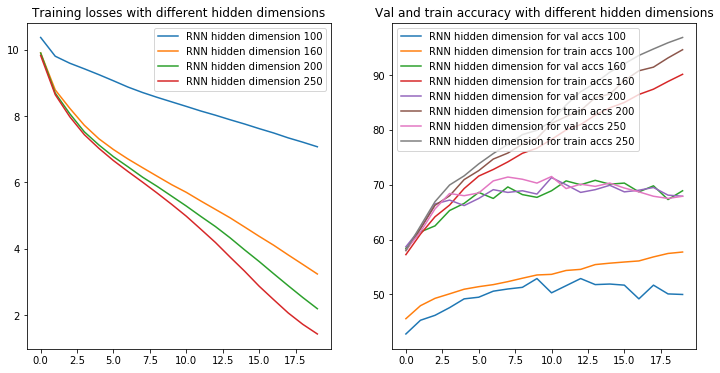

In [15]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "RNN hidden dimension " +str(hidden_sizes[i])) 

axs[0].set_title("Training losses with different hidden dimensions")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "RNN hidden dimension for val accs " +str(hidden_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "RNN hidden dimension for train accs " +str(hidden_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()



---
## Investigate whether dropout helps

In [17]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class SNLI_RNN(nn.Module):
    """
    SNLI classification model
    """
    def __init__(self, embeddings,vocab_size,emb_dim,hidden_size,num_layers,num_classes,FC_hiden):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(SNLI_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = emb_dim
        
        # pay attention to padding_idx 
        self.embed = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float(), freeze=False, sparse=False)

                

        
        self.rnn = nn.GRU(input_size=emb_dim, hidden_size=hidden_size,num_layers=num_layers,batch_first=True,
                        bidirectional=True)

        self.linear = nn.Sequential(
            #nn.Linear(hidden_size,FC_hiden),
            nn.Linear(hidden_size*2,FC_hiden),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(FC_hiden,num_classes),
            nn.ReLU())     
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).cuda()

        return hidden
    
    
    def forward(self, data_1,data_2, length_1,length_2):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        batch_size_1, seq_len_1 = data_1.size()
        batch_size_2, seq_len_2 = data_2.size()

        hidden1 = self.init_hidden(batch_size_1)
        hidden2 = self.init_hidden(batch_size_2)
   
        #S1 = self.embed(data_1)
        #print(data_1.size())
        S1 = self.embed(data_1)
        m1 = (data_1 == 1)
        #print(m1)
        m1 = m1.unsqueeze(2).repeat(1, 1, self.emb_dim).float()
        S1 = m1 * S1 + (1-m1) * S1.clone().detach()
        
 
        #print(S1.size())

        S2 = self.embed(data_2)
        m2 = (data_2 == 1)
        m2 = m2.unsqueeze(2).repeat(1, 1, self.emb_dim).float()
        S2 = m2 * S2 + (1-m2) * S2.clone().detach()

        # sort the seqs in des order
        _, idx_sort_1 = torch.sort(length_1, dim=0, descending=True)
        _, idx_unsort_1 = torch.sort(idx_sort_1, dim=0)
        S1 = S1.index_select(0, idx_sort_1)
        length_1 = list(length_1[idx_sort_1])

        _, idx_sort_2 = torch.sort(length_2, dim=0, descending=True)
        _, idx_unsort_2 = torch.sort(idx_sort_2, dim=0)
        S2 = S2.index_select(0, idx_sort_2)
        length_2 = list(length_2[idx_sort_2])
        
        #print("batch size",S1.size())

        # transform pytorch tensor to padded sequence, pack padded sequence
        S1 = torch.nn.utils.rnn.pack_padded_sequence(S1, np.array(length_1), batch_first=True)
        S2 = torch.nn.utils.rnn.pack_padded_sequence(S2, np.array(length_2), batch_first=True)
       
        _,S1 = self.rnn(S1,hidden1)
        _,S2 = self.rnn(S2,hidden2)
        
        #print("batch size",S1.size())
        
        
        S1 = torch.sum(S1,0)
        S2 = torch.sum(S2,0)
        
        #print("batch size",S2.size())

        # Unsort
        S1 = S1.index_select(0,idx_unsort_1)
        S2 = S2.index_select(0,idx_unsort_2)

        
        #out = torch.mul(S1, S2)
        out = torch.cat([S1, S2], 1)
        #print(out.size())

             
        # return logits
        out = self.linear(out)
        #print(out.size())

        return out


In [18]:
hidden_sizes = [100,160,200,250]

learning_rate = 0.0005
num_epochs = 20 # number epoch to train


train_losses=np.zeros((num_epochs,len(hidden_sizes)))
val_accs=np.zeros((num_epochs,len(hidden_sizes)))
train_accs=np.zeros((num_epochs,len(hidden_sizes)))

for count, em in enumerate(hidden_sizes):
    model = SNLI_RNN(loaded_embeddings_ft,50000,300,em,num_layers=1,num_classes=3,FC_hiden=50).cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        epoch_loss=[]
        val_acc = 0
        tra_acc = 0
        for i, (data_1,data_2, lengths_1,lengths_2, labels) in enumerate(train_loader):
            model.train()
            data_batch1,data_batch2,length_batch1,length_batch2,label_batch = data_1.cuda(),data_2.cuda(), lengths_1.cuda(),lengths_2.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(data_batch1,data_batch2, length_batch1,length_batch2)
            #print(outputs)
            #print(label_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            epoch_loss.append(loss)
            #print(np.array(loss))
            optimizer.step()
            # validate every 32 iterations
            if i > 0 and i % (BATCH_SIZE-1) == 0:
                # validate
                tra_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        temp_loss = [i.detach().cpu().numpy() for i in epoch_loss]
        train_losses[epoch,count] = sum(temp_loss)/BATCH_SIZE

        train_accs[epoch,count] = tra_acc
        val_accs[epoch,count] = val_acc
    

Epoch: [1/20], Step: [100/1000], Validation Acc: 39.8
Epoch: [1/20], Step: [199/1000], Validation Acc: 47.8
Epoch: [1/20], Step: [298/1000], Validation Acc: 54.9
Epoch: [1/20], Step: [397/1000], Validation Acc: 57.4
Epoch: [1/20], Step: [496/1000], Validation Acc: 56.5
Epoch: [1/20], Step: [595/1000], Validation Acc: 58.3
Epoch: [1/20], Step: [694/1000], Validation Acc: 58.2
Epoch: [1/20], Step: [793/1000], Validation Acc: 57.8
Epoch: [1/20], Step: [892/1000], Validation Acc: 58.9
Epoch: [1/20], Step: [991/1000], Validation Acc: 58.3
Epoch: [2/20], Step: [100/1000], Validation Acc: 60.5
Epoch: [2/20], Step: [199/1000], Validation Acc: 59.6
Epoch: [2/20], Step: [298/1000], Validation Acc: 60.3
Epoch: [2/20], Step: [397/1000], Validation Acc: 60.5
Epoch: [2/20], Step: [496/1000], Validation Acc: 61.0
Epoch: [2/20], Step: [595/1000], Validation Acc: 61.3
Epoch: [2/20], Step: [694/1000], Validation Acc: 59.8
Epoch: [2/20], Step: [793/1000], Validation Acc: 61.4
Epoch: [2/20], Step: [892/10

Epoch: [16/20], Step: [199/1000], Validation Acc: 68.7
Epoch: [16/20], Step: [298/1000], Validation Acc: 68.9
Epoch: [16/20], Step: [397/1000], Validation Acc: 67.9
Epoch: [16/20], Step: [496/1000], Validation Acc: 68.4
Epoch: [16/20], Step: [595/1000], Validation Acc: 69.5
Epoch: [16/20], Step: [694/1000], Validation Acc: 69.6
Epoch: [16/20], Step: [793/1000], Validation Acc: 69.3
Epoch: [16/20], Step: [892/1000], Validation Acc: 69.2
Epoch: [16/20], Step: [991/1000], Validation Acc: 68.6
Epoch: [17/20], Step: [100/1000], Validation Acc: 68.0
Epoch: [17/20], Step: [199/1000], Validation Acc: 69.4
Epoch: [17/20], Step: [298/1000], Validation Acc: 68.5
Epoch: [17/20], Step: [397/1000], Validation Acc: 69.3
Epoch: [17/20], Step: [496/1000], Validation Acc: 68.2
Epoch: [17/20], Step: [595/1000], Validation Acc: 69.2
Epoch: [17/20], Step: [694/1000], Validation Acc: 69.7
Epoch: [17/20], Step: [793/1000], Validation Acc: 69.1
Epoch: [17/20], Step: [892/1000], Validation Acc: 68.1
Epoch: [17

Epoch: [11/20], Step: [298/1000], Validation Acc: 68.0
Epoch: [11/20], Step: [397/1000], Validation Acc: 68.8
Epoch: [11/20], Step: [496/1000], Validation Acc: 68.1
Epoch: [11/20], Step: [595/1000], Validation Acc: 68.0
Epoch: [11/20], Step: [694/1000], Validation Acc: 67.9
Epoch: [11/20], Step: [793/1000], Validation Acc: 68.5
Epoch: [11/20], Step: [892/1000], Validation Acc: 68.6
Epoch: [11/20], Step: [991/1000], Validation Acc: 68.4
Epoch: [12/20], Step: [100/1000], Validation Acc: 67.9
Epoch: [12/20], Step: [199/1000], Validation Acc: 67.1
Epoch: [12/20], Step: [298/1000], Validation Acc: 68.8
Epoch: [12/20], Step: [397/1000], Validation Acc: 69.0
Epoch: [12/20], Step: [496/1000], Validation Acc: 68.6
Epoch: [12/20], Step: [595/1000], Validation Acc: 68.9
Epoch: [12/20], Step: [694/1000], Validation Acc: 68.6
Epoch: [12/20], Step: [793/1000], Validation Acc: 69.3
Epoch: [12/20], Step: [892/1000], Validation Acc: 68.0
Epoch: [12/20], Step: [991/1000], Validation Acc: 69.9
Epoch: [13

Epoch: [6/20], Step: [298/1000], Validation Acc: 66.0
Epoch: [6/20], Step: [397/1000], Validation Acc: 67.4
Epoch: [6/20], Step: [496/1000], Validation Acc: 65.4
Epoch: [6/20], Step: [595/1000], Validation Acc: 65.9
Epoch: [6/20], Step: [694/1000], Validation Acc: 66.3
Epoch: [6/20], Step: [793/1000], Validation Acc: 67.3
Epoch: [6/20], Step: [892/1000], Validation Acc: 67.5
Epoch: [6/20], Step: [991/1000], Validation Acc: 67.8
Epoch: [7/20], Step: [100/1000], Validation Acc: 66.9
Epoch: [7/20], Step: [199/1000], Validation Acc: 67.6
Epoch: [7/20], Step: [298/1000], Validation Acc: 67.1
Epoch: [7/20], Step: [397/1000], Validation Acc: 69.0
Epoch: [7/20], Step: [496/1000], Validation Acc: 67.7
Epoch: [7/20], Step: [595/1000], Validation Acc: 68.5
Epoch: [7/20], Step: [694/1000], Validation Acc: 68.0
Epoch: [7/20], Step: [793/1000], Validation Acc: 67.2
Epoch: [7/20], Step: [892/1000], Validation Acc: 67.9
Epoch: [7/20], Step: [991/1000], Validation Acc: 66.2
Epoch: [8/20], Step: [100/10

Epoch: [1/20], Step: [298/1000], Validation Acc: 47.2
Epoch: [1/20], Step: [397/1000], Validation Acc: 55.4
Epoch: [1/20], Step: [496/1000], Validation Acc: 57.8
Epoch: [1/20], Step: [595/1000], Validation Acc: 58.0
Epoch: [1/20], Step: [694/1000], Validation Acc: 59.0
Epoch: [1/20], Step: [793/1000], Validation Acc: 57.9
Epoch: [1/20], Step: [892/1000], Validation Acc: 59.4
Epoch: [1/20], Step: [991/1000], Validation Acc: 59.2
Epoch: [2/20], Step: [100/1000], Validation Acc: 60.8
Epoch: [2/20], Step: [199/1000], Validation Acc: 59.7
Epoch: [2/20], Step: [298/1000], Validation Acc: 60.4
Epoch: [2/20], Step: [397/1000], Validation Acc: 61.2
Epoch: [2/20], Step: [496/1000], Validation Acc: 61.3
Epoch: [2/20], Step: [595/1000], Validation Acc: 61.5
Epoch: [2/20], Step: [694/1000], Validation Acc: 61.2
Epoch: [2/20], Step: [793/1000], Validation Acc: 60.3
Epoch: [2/20], Step: [892/1000], Validation Acc: 61.5
Epoch: [2/20], Step: [991/1000], Validation Acc: 60.9
Epoch: [3/20], Step: [100/10

Epoch: [16/20], Step: [397/1000], Validation Acc: 68.1
Epoch: [16/20], Step: [496/1000], Validation Acc: 69.3
Epoch: [16/20], Step: [595/1000], Validation Acc: 68.0
Epoch: [16/20], Step: [694/1000], Validation Acc: 68.6
Epoch: [16/20], Step: [793/1000], Validation Acc: 68.1
Epoch: [16/20], Step: [892/1000], Validation Acc: 67.4
Epoch: [16/20], Step: [991/1000], Validation Acc: 68.1
Epoch: [17/20], Step: [100/1000], Validation Acc: 67.7
Epoch: [17/20], Step: [199/1000], Validation Acc: 67.9
Epoch: [17/20], Step: [298/1000], Validation Acc: 68.0
Epoch: [17/20], Step: [397/1000], Validation Acc: 68.4
Epoch: [17/20], Step: [496/1000], Validation Acc: 67.8
Epoch: [17/20], Step: [595/1000], Validation Acc: 68.1
Epoch: [17/20], Step: [694/1000], Validation Acc: 69.1
Epoch: [17/20], Step: [793/1000], Validation Acc: 68.5
Epoch: [17/20], Step: [892/1000], Validation Acc: 68.2
Epoch: [17/20], Step: [991/1000], Validation Acc: 68.8
Epoch: [18/20], Step: [100/1000], Validation Acc: 68.6
Epoch: [18

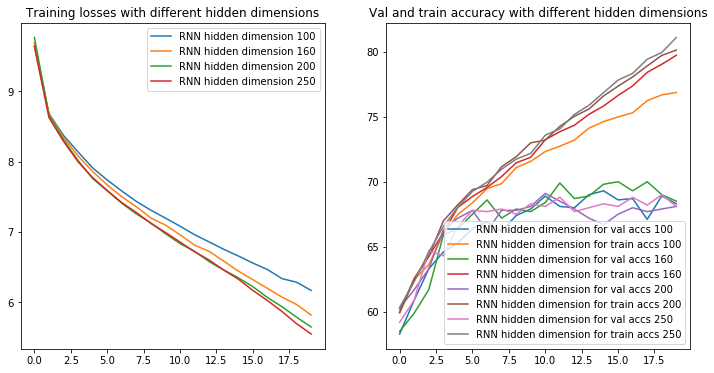

In [19]:
# Plot the results
fig, axs = plt.subplots(1,2,figsize=(12,6))
for i in range(len(train_losses[0,:])):
    axs[0].plot(train_losses[:,i],label= "RNN hidden dimension " +str(hidden_sizes[i])) 

axs[0].set_title("Training losses with different hidden dimensions")
axs[0].legend()

for i in range(len(val_accs[0,:])):
    axs[1].plot(val_accs[:,i],label= "RNN hidden dimension for val accs " +str(hidden_sizes[i])) 
    axs[1].plot(train_accs[:,i],label= "RNN hidden dimension for train accs " +str(hidden_sizes[i])) 

axs[1].set_title("Val and train accuracy with different hidden dimensions")
axs[1].legend()

